In [2]:
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [3]:
img  = cv2.imread("test_images/virat_kohli1.png")
img.shape

(374, 374, 3)

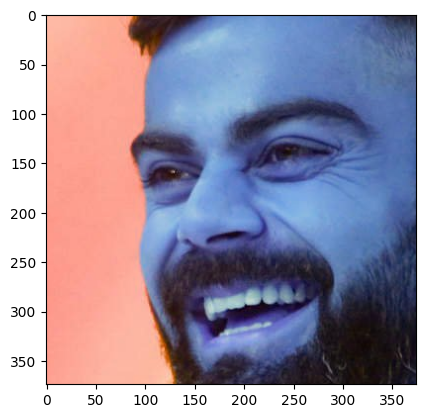

In [5]:
plt.imshow(img)

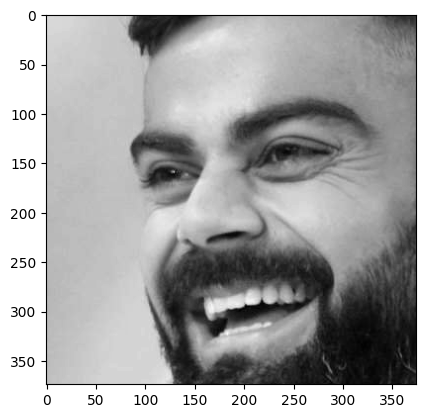

In [9]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')

**Doing Wavelet transform**

In [ ]:
import pywt
def w2d(img, mode='haar',level=1):
    imArray = img
img_har = w2d(img,'db1',5)